# ARMA task
Learn an autoregressive moving average model (see Wikipedia for an introduction if unfamiliar) for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (R, statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model.

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [4]:
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = pd.datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = pd.read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = pd.read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,2014-01-06,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,2014-01-06,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,2014-01-06,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,2014-01-06,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,2014-01-06,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


## Check autocorrelation
Apply Durbin Watson test to examine autocorrelation in the data. The test will return a value between 0 and 4.
- A value of 2.0 means there is no autocorrelation detected in the sample. 
- Values from zero to 2.0 indicate positive autocorrelation.
- Values from 2.0 to 4.0 indicate negative autocorrelation.

In [9]:
sm.stats.durbin_watson(df_1['L_T1'])

0.006432171620535719

## Identifying the order of differencing(d) in ARIMA model

In [15]:
result = adfuller(df_1['L_T3'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.375782
p-value: 0.000000


## Diagnosing ACF and PACF plots

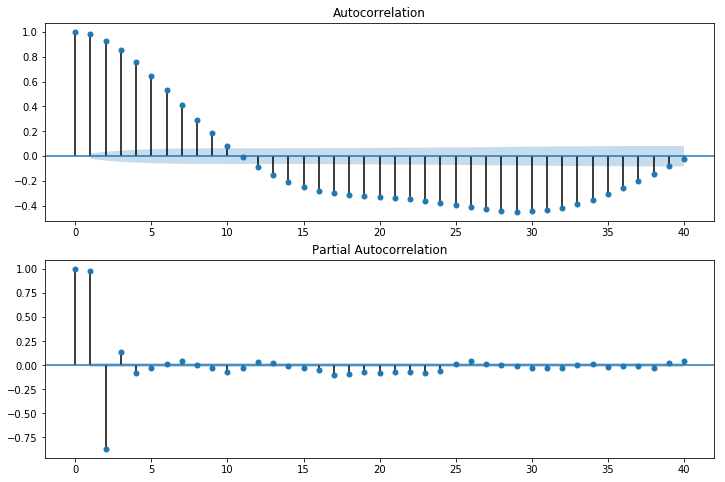

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1['L_T1'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1['L_T1'], lags=40, ax=ax2)

### Apply ARIMA

                              ARMA Model Results                              
Dep. Variable:                   L_T3   No. Observations:                 8761
Model:                     ARMA(1, 2)   Log Likelihood                 427.610
Method:                       css-mle   S.D. of innovations              0.230
Date:                Mon, 03 Jun 2019   AIC                           -845.220
Time:                        14:45:33   BIC                           -809.829
Sample:                             0   HQIC                          -833.161
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2013      0.019    226.864      0.000       4.165       4.238
ar.L1.L_T3     0.6539      0.009     70.246      0.000       0.636       0.672
ma.L1.L_T3     1.0618      0.010    102.465      0.0

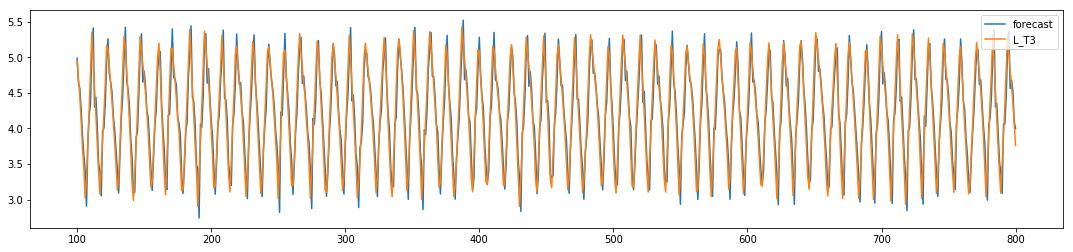

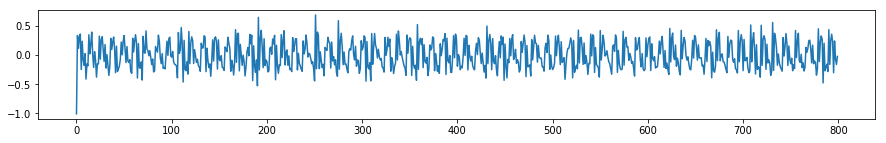

In [31]:
model = ARIMA(df_1['L_T3'], order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
print(model_fit.arparams)
print(model_fit.maparams)

# Actual vs Fitted
fig = model_fit.plot_predict(dynamic=False, start=100, end=800)
fig.set_size_inches(18.5, 4)
plt.show()

# Plot residual
plt.figure(figsize=(15,2))
plt.plot(model_fit.resid[0:800])
plt.show()


In [22]:
def grid_search(data):
    best_order = None
    best_score = float('Inf')
    for p in range(0, 6):
        for d in range(0, 2):
            for q in range(0, 4):
                order = (p, d, q)
                try:
                    model = ARIMA(data, order=order)
                    model_fit = model.fit(disp=0, trend='nc')
                    aic = model_fit.aic
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                    
                    if (aic < best_score):
                        best_order = order
                        best_score = aic
                except:
                    continue
    
    print('Best ARIMA%s AIC=%.3f' % (best_order, best_score))

In [23]:
grid_search(df_1['L_T3'])

ARIMA(0, 0, 1) AIC=38456.054
ARIMA(0, 1, 1) AIC=2556.822
ARIMA(0, 1, 3) AIC=668.917
ARIMA(1, 0, 0) AIC=7878.319
ARIMA(1, 0, 1) AIC=2537.836
ARIMA(1, 0, 2) AIC=652.784
ARIMA(1, 0, 3) AIC=2167.369
ARIMA(1, 1, 0) AIC=1654.185
ARIMA(1, 1, 1) AIC=7186.397
ARIMA(2, 0, 0) AIC=1556.620
ARIMA(2, 0, 1) AIC=657.878
ARIMA(2, 1, 0) AIC=236.059
ARIMA(2, 1, 3) AIC=-7326.300
ARIMA(3, 0, 0) AIC=196.690
ARIMA(3, 0, 3) AIC=-7278.234
ARIMA(3, 1, 0) AIC=-216.990


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3) AIC=-7382.666
ARIMA(4, 0, 0) AIC=-239.217


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 0, 3) AIC=-5394.524
ARIMA(4, 1, 0) AIC=-1856.638
ARIMA(4, 1, 2) AIC=-7579.337
ARIMA(5, 0, 0) AIC=-1861.376


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 2) AIC=-7450.007
ARIMA(5, 1, 0) AIC=-4093.213
ARIMA(5, 1, 2) AIC=-7432.344
Best ARIMA(4, 1, 2) AIC=-7579.337
